## 1. Import Libraries and Set Device

In [19]:
# ========== Standard Libraries ==========
import csv
import os
import time
import warnings
from datetime import datetime

# ========== Data Handling & ML ==========
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ========== Deep Learning (PyTorch) ==========
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# ========== Image Processing & Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# ========== Utilities ==========
from tqdm import tqdm
import joblib


In [20]:
# Set the device for PyTorch computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print(f"Using {device} device")
print(f"CUDA Available: {torch.cuda.is_available()}")

# If CUDA is available, print additional details
if torch.cuda.is_available():
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    print(f"Current CUDA Device: {torch.cuda.current_device()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using cuda device
CUDA Available: True
Number of CUDA Devices: 1
Current CUDA Device: 0
CUDA Device Name: NVIDIA GeForce RTX 4060 Ti


## 2. Data Loading and Preprocessing

In [21]:
root_dir = "lung_colon_image_set"
image_paths = []
multi_labels = []

label_mapping = {
    'lung_n': 0, 'lung_aca': 1, 'lung_scc': 2,
    'colon_n': 3, 'colon_aca': 4
}

class_names = list(label_mapping.keys())

for subfolder in ['lung_image_sets/lung_n', 'lung_image_sets/lung_aca', 'lung_image_sets/lung_scc',
                  'colon_image_sets/colon_n', 'colon_image_sets/colon_aca']:
    class_dir = os.path.join(root_dir, subfolder)
    class_name = subfolder.split('/')[-1]

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        multi_labels.append(label_mapping[class_name])

print(f"Total Image: {len(image_paths)}")


Total Image: 25000


In [22]:
# Simplified transform for training data (no heavy augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match EfficientNet input
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet mean
                         std=[0.229, 0.224, 0.225])   # Standard ImageNet std
])

# Same transform for test/validation data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [23]:
class FeatureDataset(Dataset):
    def __init__(self, image_paths, multi_labels, transform=None):
        self.image_paths = image_paths
        self.multi_labels = multi_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.multi_labels[idx]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, 
    multi_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=multi_labels
)

# Create datasets with respective transformations
train_dataset = FeatureDataset(X_train, y_train, transform=train_transform)
test_dataset = FeatureDataset(X_test, y_test, transform=test_transform)

# Create data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 3. EfficientNetB3 For Feature Extraction

In [25]:
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
model.classifier = torch.nn.Identity() 
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [26]:
def extract_features(dataloader, model, device='cuda'):
    all_features = []
    all_labels = []

    print("Extracting features...")
    start_time = time.time()

    model.eval()  # Ensure the model is in evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            features = model(inputs)
            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Feature extraction completed in {elapsed:.2f} seconds.")

    return np.concatenate(all_features), np.array(all_labels)

In [27]:
X_train_feat, y_train = extract_features(train_loader, model, device)
X_test_feat, y_test = extract_features(test_loader, model, device)

Extracting features...
Feature extraction completed in 143.34 seconds.
Extracting features...
Feature extraction completed in 35.55 seconds.


In [28]:
print(f"Train Feature Shape: {X_train_feat.shape}")
print(f"Test Feature Shape: {X_test_feat.shape}")
print(f"Train Label Shape: {y_train.shape}")
print(f"Test Label Shape: {y_test.shape}")

Train Feature Shape: (20000, 1536)
Test Feature Shape: (5000, 1536)
Train Label Shape: (20000,)
Test Label Shape: (5000,)


## 4. Needed Function For Test and Eval

In [29]:
def filter_dataset_by_class(X_train_feat, y_train, X_test_feat, y_test, class_range):
    # Get indices of the classes within the class_range
    train_indices = np.where(np.isin(y_train, class_range))[0]
    test_indices = np.where(np.isin(y_test, class_range))[0]

    # Filter the data based on the selected class_range
    X_train = X_train_feat[train_indices]
    y_train_filtered = y_train[train_indices] - min(class_range)

    X_test = X_test_feat[test_indices]
    y_test_filtered = y_test[test_indices] - min(class_range)

    return X_train, y_train_filtered, X_test, y_test_filtered


In [30]:
def save_best_model(model, model_name, task_name, accuracy, f1_score, precision, recall):
    # Create the models directory if it doesn't exist
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    # Save the model to a joblib file
    filename = f"{models_dir}/{task_name.replace(' ', '_').lower()}_{model_name.replace(' ', '_').lower()}.joblib"
    joblib.dump(model, filename)
    print(f"Saved best model '{model_name}' for {task_name} as: {filename}")

    # Log the model performance to a CSV file
    log_filename = f"{models_dir}/model_performance.csv"

    # Prepare performance data
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    performance_data = {
        'timestamp': timestamp,
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'precision': precision,
        'recall': recall
    }

    # Check if the log file exists, if not, create it with headers
    if not os.path.exists(log_filename):
        df = pd.DataFrame(columns=['timestamp', 'model_name', 'accuracy', 'f1_score', 'precision', 'recall'])
        df.to_csv(log_filename, index=False)

    # Append the performance data to the CSV file
    df = pd.DataFrame([performance_data])
    df.to_csv(log_filename, mode='a', header=False, index=False)
    print(f"Saved model performance to: {log_filename}")

In [31]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, class_names):

    # Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"\n--- {model_name} ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("Accuracy:", acc)
    print("F1 Score (weighted):", f1)
    print("Precision (weighted):", precision)
    print("Recall (weighted):", recall) 

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return model_name, acc, f1, precision, recall

In [32]:
def evaluate_cancer_classifiers(X_train_feat, y_train, X_test_feat, y_test,
                                 class_range, class_names, task_name="Cancer Classification"):
    
    # Filter data based on class_range
    X_train, y_train_filtered, X_test, y_test_filtered = filter_dataset_by_class(
        X_train_feat, y_train, X_test_feat, y_test, class_range
    )

    # Define the models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM (Linear)": SVC(kernel='linear', probability=True),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }

    acc_list, f1_list, precision_list, recall_list = [], [], [], []
    training_times = []  # List to store training times
    trained_models = {}

    print(f"\n========== {task_name} Evaluation ==========")
    print(f"Classes: {class_names}")

    # Iterate over all models and evaluate them
    for name, model in models.items():
        start_time = time.time()  # Capture start time
        acc_model, acc, f1, precision, recall = train_and_evaluate_model(
            model, name, X_train, y_train_filtered, X_test, y_test_filtered, class_names
        )
        end_time = time.time()  # Capture end time
        training_time = end_time - start_time  # Calculate training time

        # Append values for accuracy, F1, precision, recall
        acc_list.append((acc_model, acc))
        f1_list.append((acc_model, f1))
        precision_list.append((acc_model, precision))
        recall_list.append((acc_model, recall))
        training_times.append(training_time)  # Store the training time
        trained_models[name] = model
        print(f"Training time for {name}: {training_time:.2f} seconds")

    # Determine the best model based on F1 score
    best_model_name, _ = max(f1_list, key=lambda x: x[1])
    best_model = trained_models[best_model_name]

    # Extract the associated metric values
    best_accuracy = dict(acc_list)[best_model_name]
    best_f1 = dict(f1_list)[best_model_name]
    best_precision = dict(precision_list)[best_model_name]
    best_recall = dict(recall_list)[best_model_name]

    # Save best model and metrics
    save_best_model(best_model, best_model_name, task_name,
                    best_accuracy, best_f1, best_precision, best_recall)

    # Visualization of performance (Accuracy and F1 Score)
    model_names = [x[0] for x in acc_list]
    acc_values = [x[1] for x in acc_list]
    f1_values = [x[1] for x in f1_list]

    x = np.arange(len(model_names))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, acc_values, width, label='Accuracy', color='skyblue')
    plt.bar(x + width/2, f1_values, width, label='F1 Score', color='salmon')
    plt.xticks(x, model_names, rotation=45)
    plt.ylabel("Score")
    plt.title(f"{task_name} - Model Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualization of Training Times
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, training_times, color='lightgreen')
    plt.xlabel("Model")
    plt.ylabel("Training Time (seconds)")
    plt.title(f"{task_name} - Training Time Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nClassification and model saving completed.")
    
    return best_model


## 5. Lung Cancer Ops


========== Lung Cancer Evaluation ==========
Classes: ['lung_n', 'lung_aca', 'lung_scc']

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.99      0.99      0.99      1000
    lung_aca       0.96      0.97      0.96      1000
    lung_scc       0.98      0.97      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

Accuracy: 0.9753333333333334
F1 Score (weighted): 0.9753274240978212
Precision (weighted): 0.9753511928244406
Recall (weighted): 0.9753333333333334


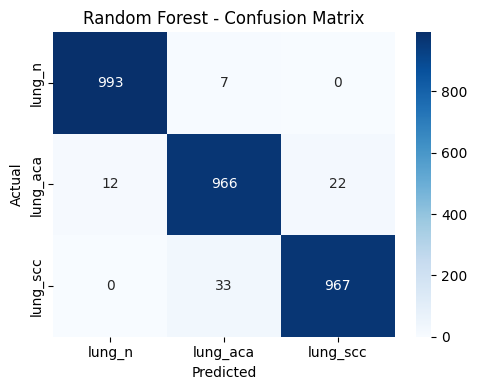

Training time for Random Forest: 54.66 seconds

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00      1000
    lung_aca       0.99      0.99      0.99      1000
    lung_scc       0.99      0.99      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 0.9946666666666667
F1 Score (weighted): 0.9946646639979974
Precision (weighted): 0.9946639893226238
Recall (weighted): 0.9946666666666667


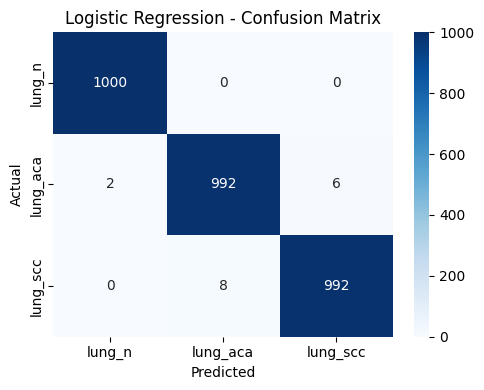

Training time for Logistic Regression: 1.30 seconds

--- SVM (Linear) ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00      1000
    lung_aca       0.99      0.99      0.99      1000
    lung_scc       0.99      0.99      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 0.994
F1 Score (weighted): 0.99399732999733
Precision (weighted): 0.9939959866506133
Recall (weighted): 0.994


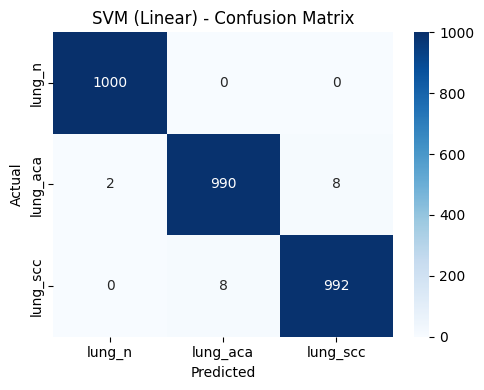

Training time for SVM (Linear): 26.18 seconds

--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       0.97      0.96      0.96      1000
    lung_aca       0.89      0.90      0.90      1000
    lung_scc       0.93      0.93      0.93      1000

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

Accuracy: 0.9286666666666666
F1 Score (weighted): 0.9287078687769688
Precision (weighted): 0.9287531479359609
Recall (weighted): 0.9286666666666666


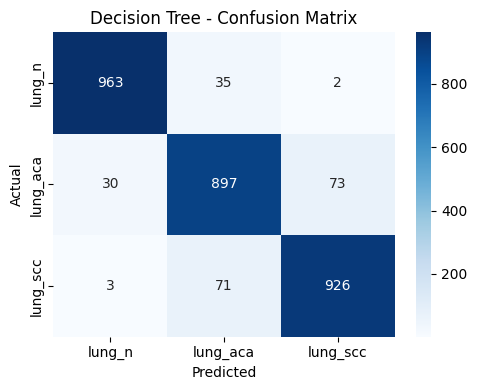

Training time for Decision Tree: 66.00 seconds


c:\Users\burakdogan\Desktop\Ders\DeepLearning\LungColon\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [03:09:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00      1000
    lung_aca       0.99      0.98      0.99      1000
    lung_scc       0.99      0.99      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 0.9903333333333333
F1 Score (weighted): 0.9903301520705138
Precision (weighted): 0.9903292779135877
Recall (weighted): 0.9903333333333333


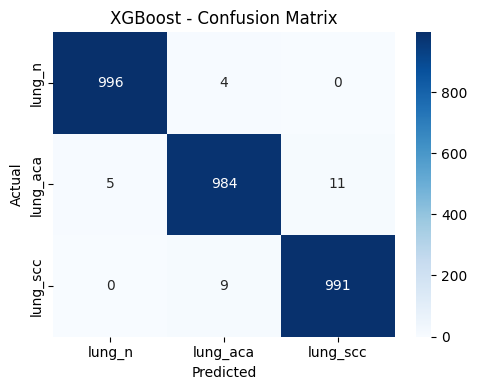

Training time for XGBoost: 35.66 seconds
Saved best model 'Logistic Regression' for Lung Cancer as: models/lung_cancer_logistic_regression.joblib
Saved model performance to: models/model_performance.csv


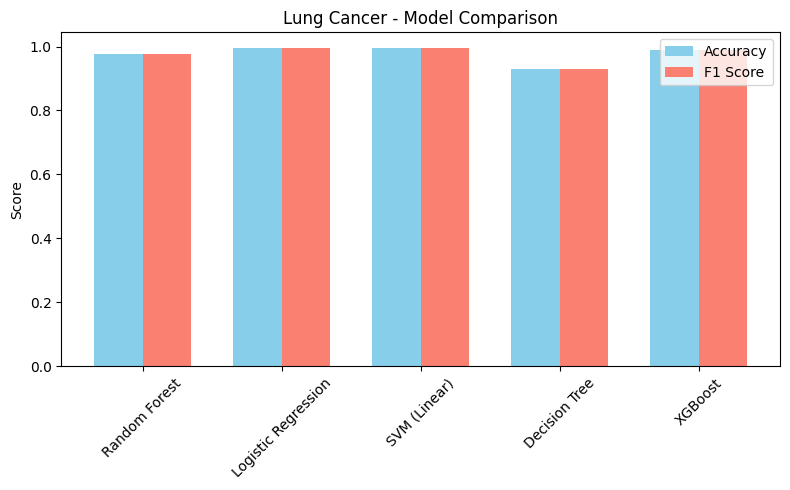

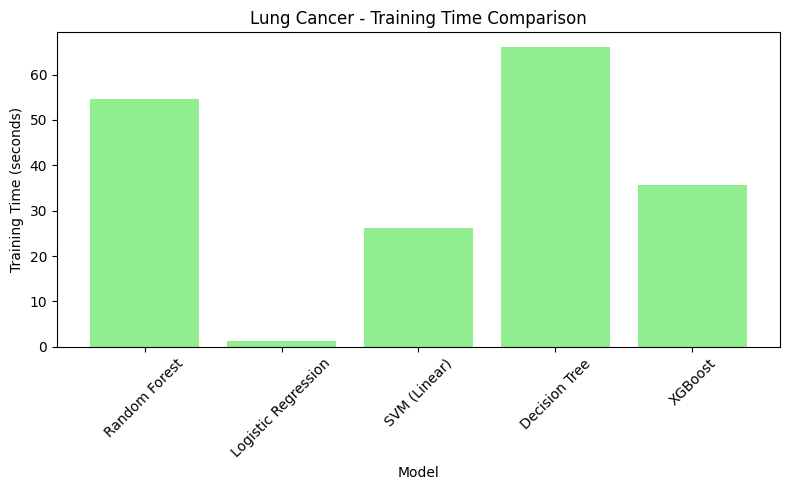


Classification and model saving completed.


In [33]:
best_lung_model = evaluate_cancer_classifiers(
    X_train_feat, y_train,  # Use scaled features
    X_test_feat, y_test,  # Use scaled test features
    class_range=range(0, 3),
    class_names=['lung_n', 'lung_aca', 'lung_scc'],
    task_name="Lung Cancer"
)


## 6. Colon Cancer Ops


========== Colon Cancer Evaluation ==========
Classes: ['colon_n', 'colon_aca']

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      0.99      0.99      1000
   colon_aca       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Accuracy: 0.993
F1 Score (weighted): 0.9929998249956249
Precision (weighted): 0.993049304930493
Recall (weighted): 0.993


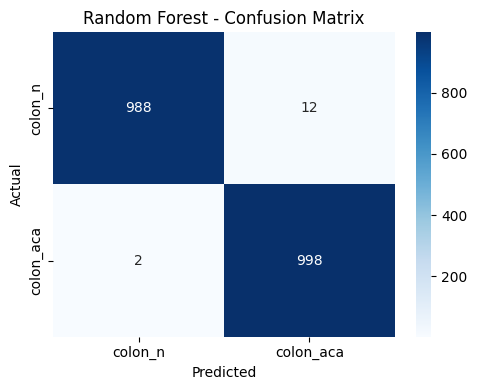

Training time for Random Forest: 31.36 seconds

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 0.9995
F1 Score (weighted): 0.9994999998749999
Precision (weighted): 0.9995004995004995
Recall (weighted): 0.9995


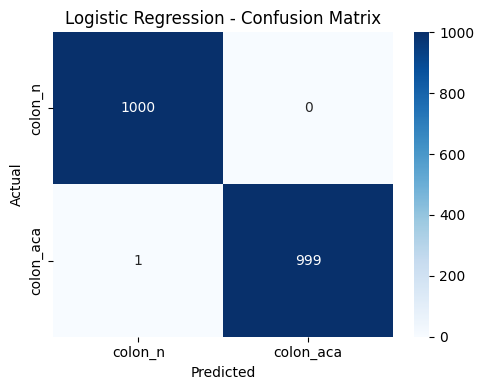

Training time for Logistic Regression: 0.25 seconds

--- SVM (Linear) ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 0.9995
F1 Score (weighted): 0.9994999998749999
Precision (weighted): 0.9995004995004995
Recall (weighted): 0.9995


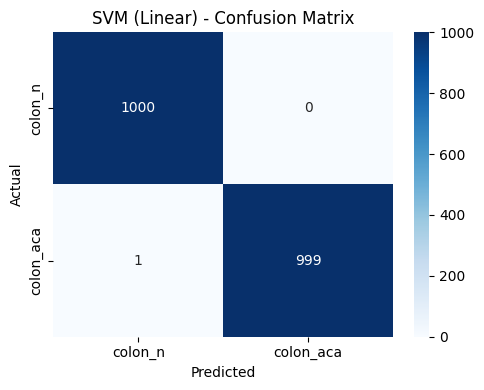

Training time for SVM (Linear): 5.80 seconds

--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       0.97      0.97      0.97      1000
   colon_aca       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

Accuracy: 0.969
F1 Score (weighted): 0.9689999689999691
Precision (weighted): 0.9690018760075041
Recall (weighted): 0.969


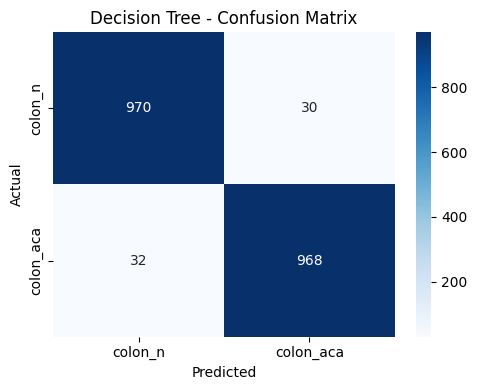

Training time for Decision Tree: 22.65 seconds


c:\Users\burakdogan\Desktop\Ders\DeepLearning\LungColon\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [03:11:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      0.99      1.00      1000
   colon_aca       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 0.9955
F1 Score (weighted): 0.9954999988749997
Precision (weighted): 0.9955004955004954
Recall (weighted): 0.9955


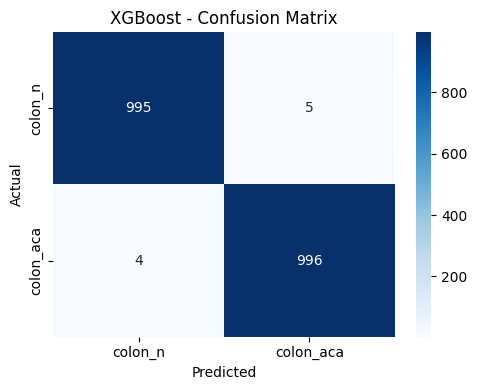

Training time for XGBoost: 7.52 seconds
Saved best model 'Logistic Regression' for Colon Cancer as: models/colon_cancer_logistic_regression.joblib
Saved model performance to: models/model_performance.csv


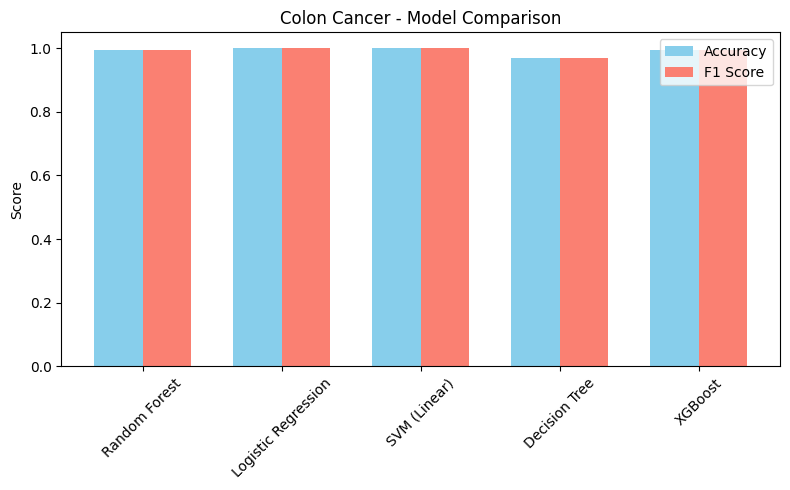

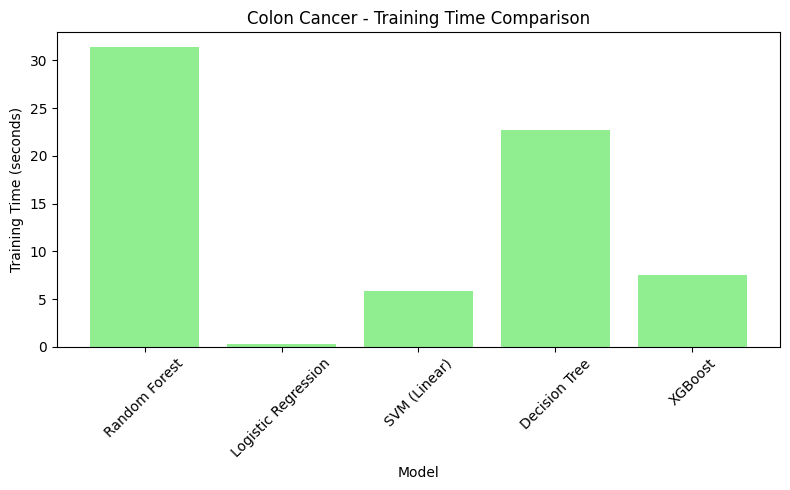


Classification and model saving completed.


In [34]:
best_colon_model = evaluate_cancer_classifiers(
    X_train_feat, y_train,  # Use scaled features
    X_test_feat, y_test,  # Use scaled test features
    class_range=range(3, 5),
    class_names=['colon_n', 'colon_aca'],
    task_name="Colon Cancer"
)

## 5. Stacking Ensemble Learning

In [ ]:
lung_preds_train = best_lung_model.predict_proba(X_train_feat)  # (N, num_classes_lung)
colon_preds_train = best_colon_model.predict_proba(X_train_feat)  # (N, num_classes_colon)

# Stack the predictions from both models to create the input for the meta-model
meta_X_train = np.hstack([lung_preds_train, colon_preds_train])

meta_y_train = y_train

# Predict using the test data
lung_preds_test = best_lung_model.predict_proba(X_test_feat)  # (N, num_classes_lung)
colon_preds_test = best_colon_model.predict_proba(X_test_feat)  # (N, num_classes_colon)

# Stack the predictions from both models to create the input for the meta-model
meta_X_test = np.hstack([lung_preds_test, colon_preds_test])


========== Lung and Colon Cancer Evaluation ==========
Classes: ['colon_n', 'colon_aca', 'lung_n', 'lung_aca', 'lung_scc']

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       0.80      0.80      0.80      1000
      lung_n       0.96      0.95      0.95      1000
    lung_aca       0.97      0.98      0.98      1000
    lung_scc       0.79      0.79      0.79      1000

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000

Accuracy: 0.9034
F1 Score (weighted): 0.9033008682784303
Precision (weighted): 0.9032172502660938
Recall (weighted): 0.9034


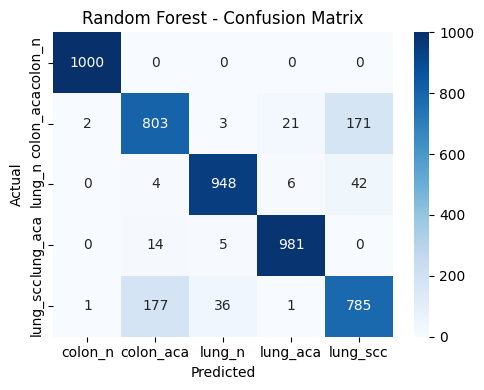

Training time for Random Forest: 3.05 seconds

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       0.64      0.86      0.74      1000
      lung_n       0.84      0.97      0.90      1000
    lung_aca       0.94      0.98      0.96      1000
    lung_scc       0.78      0.36      0.49      1000

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.82      5000
weighted avg       0.84      0.83      0.82      5000

Accuracy: 0.8342
F1 Score (weighted): 0.8176719797097785
Precision (weighted): 0.840199725045835
Recall (weighted): 0.8342


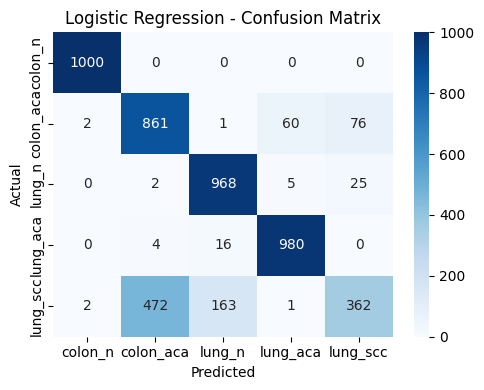

Training time for Logistic Regression: 0.24 seconds

--- SVM (Linear) ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       0.60      0.90      0.72      1000
      lung_n       0.83      0.97      0.89      1000
    lung_aca       0.95      0.96      0.95      1000
    lung_scc       0.77      0.24      0.37      1000

    accuracy                           0.81      5000
   macro avg       0.83      0.81      0.79      5000
weighted avg       0.83      0.81      0.79      5000

Accuracy: 0.8142
F1 Score (weighted): 0.7868457781036832
Precision (weighted): 0.8284077946250858
Recall (weighted): 0.8142


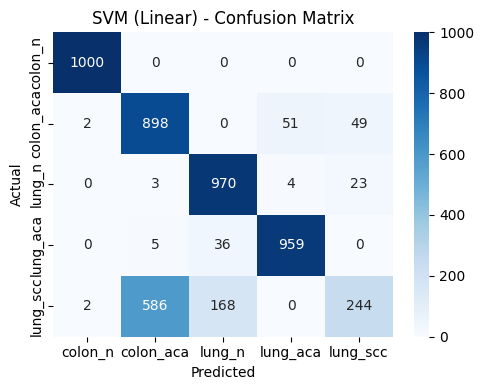

Training time for SVM (Linear): 4.88 seconds

--- Decision Tree ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       0.76      0.76      0.76      1000
      lung_n       0.93      0.92      0.93      1000
    lung_aca       0.96      0.97      0.97      1000
    lung_scc       0.73      0.74      0.74      1000

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

Accuracy: 0.8786
F1 Score (weighted): 0.8786418317195949
Precision (weighted): 0.8786986383836498
Recall (weighted): 0.8786


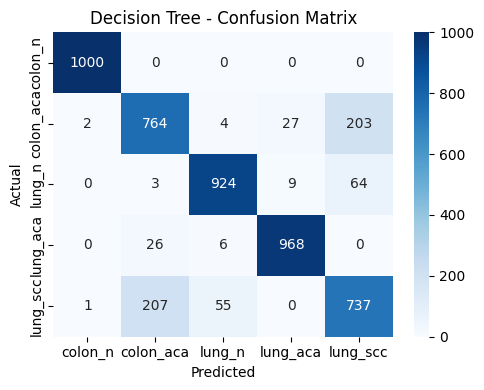

Training time for Decision Tree: 0.24 seconds


c:\Users\burakdogan\Desktop\Ders\DeepLearning\LungColon\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [03:11:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

     colon_n       1.00      1.00      1.00      1000
   colon_aca       0.81      0.81      0.81      1000
      lung_n       0.95      0.95      0.95      1000
    lung_aca       0.98      0.98      0.98      1000
    lung_scc       0.79      0.79      0.79      1000

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

Accuracy: 0.906
F1 Score (weighted): 0.9058610747931558
Precision (weighted): 0.9057290961783733
Recall (weighted): 0.906


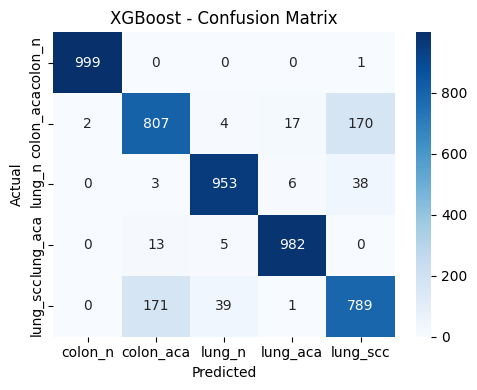

Training time for XGBoost: 0.54 seconds
Saved best model 'XGBoost' for Lung and Colon Cancer as: models/lung_and_colon_cancer_xgboost.joblib
Saved model performance to: models/model_performance.csv


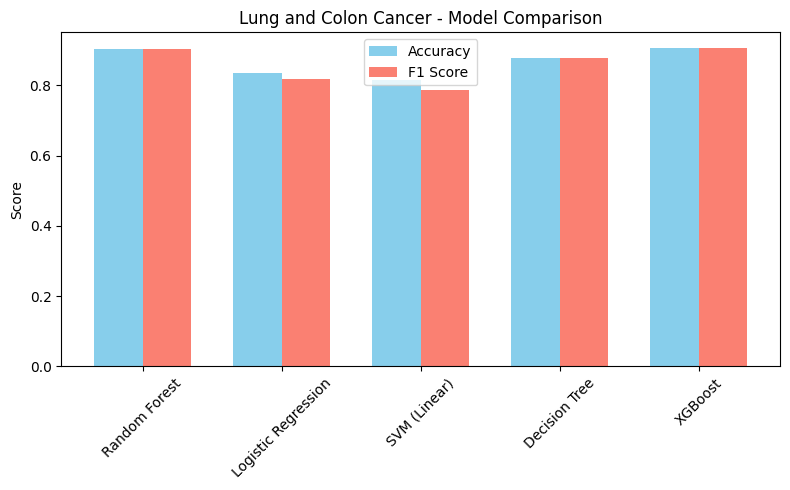

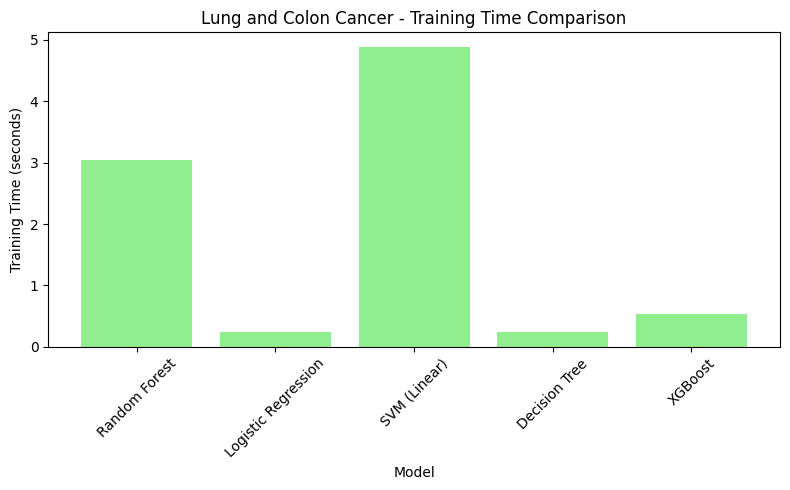


Classification and model saving completed.


In [36]:
# Evaluate the meta-model with the stacked predictions
best_meta_model = evaluate_cancer_classifiers(
    meta_X_train, meta_y_train,  # Use stacked predictions as the features for meta-model
    meta_X_test, y_test,  # Use stacked test predictions and original test labels
    class_range=range(0, 5),
    class_names=['colon_n', 'colon_aca', 'lung_n', 'lung_aca', 'lung_scc'],
    task_name="Lung and Colon Cancer"
)